### This notebook looks at the impact of systematically deleting SC ...

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting
from whobpyt.optimization import cost_funs

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
pwd

'/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch'

In [3]:
from collections import Counter

In [4]:
import seaborn as sns
import scipy.stats as stats

In [5]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 5s, sys: 1.37 s, total: 1min 7s
Wall time: 1min 48s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.38 s, sys: 164 ms, total: 1.55 s
Wall time: 1.9 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_sommot_lesion = []
all_subs_dorsattn_lesion = []
all_subs_ventattn_lesion = []
all_subs_limbic_lesion = []
all_subs_fpn_lesion = []
all_subs_dmn_lesion = []


for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    
    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
    
    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
    
    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
    

CPU times: user 1min 51s, sys: 4.38 s, total: 1min 56s
Wall time: 5min 12s


In [14]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

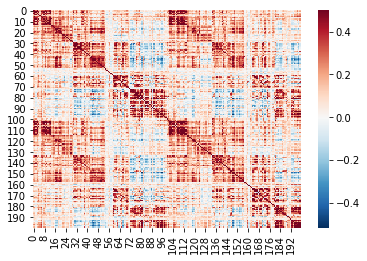

In [15]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

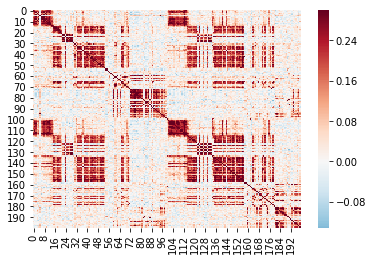

In [16]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [17]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [18]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [19]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [20]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [27]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc

### original whobpyt 

In [28]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 842 ms, sys: 10.3 ms, total: 852 ms
Wall time: 815 ms


In [29]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [30]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

### lesion whobpyt

In [31]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [32]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.65 s, sys: 381 ms, total: 6.03 s
Wall time: 6.01 s


In [33]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [34]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]

vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

In [35]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

####  Visual

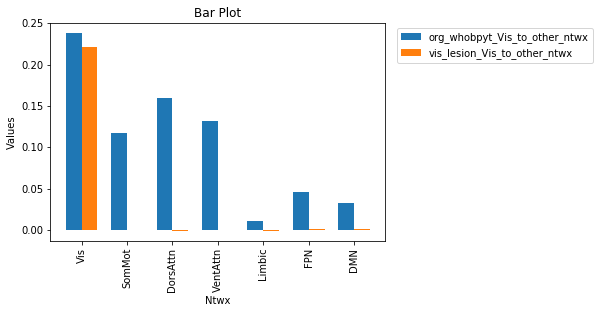

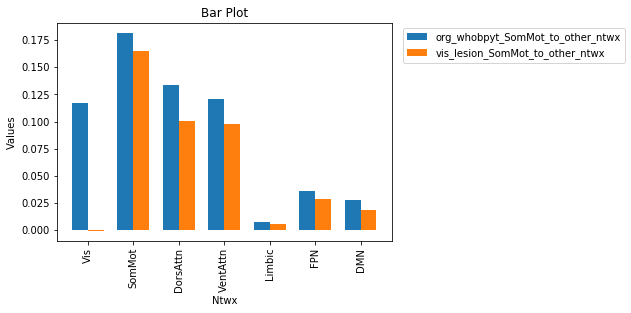

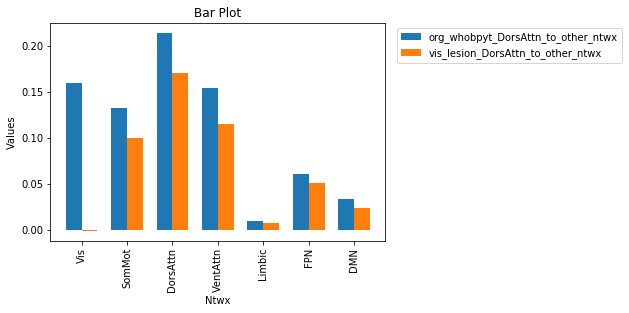

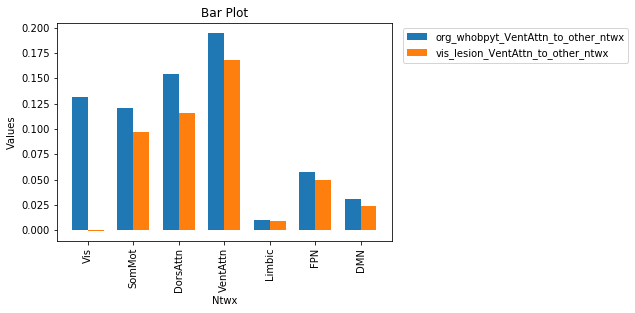

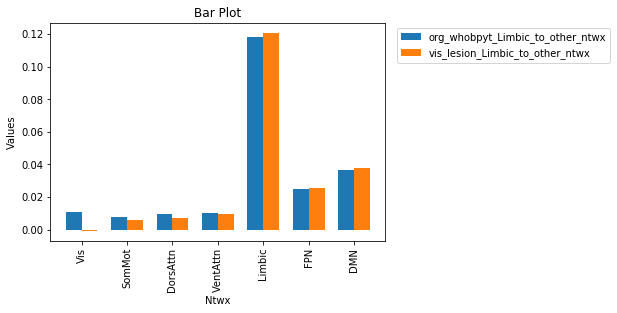

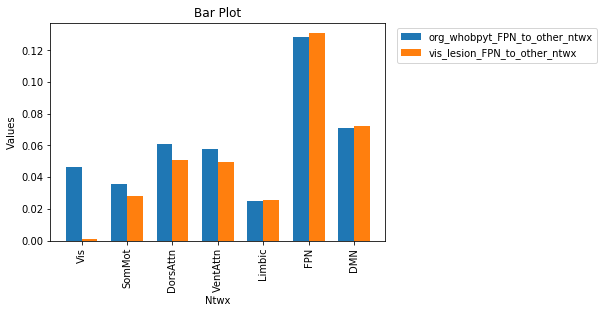

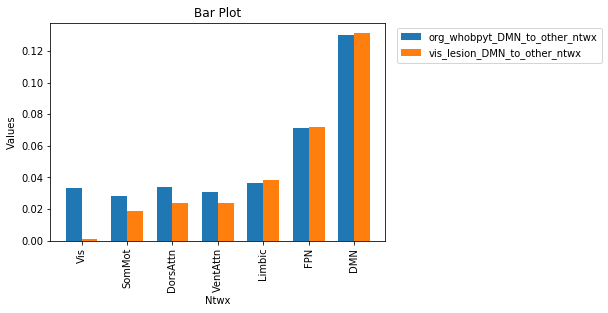

In [36]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx[j], width, label='vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

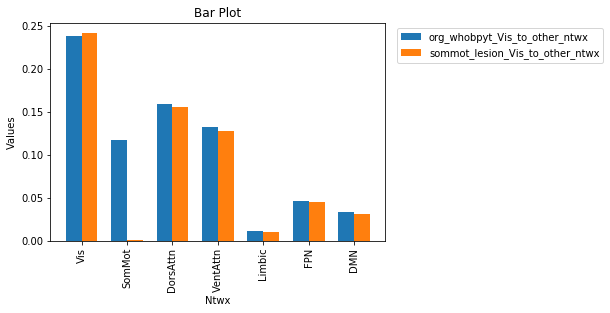

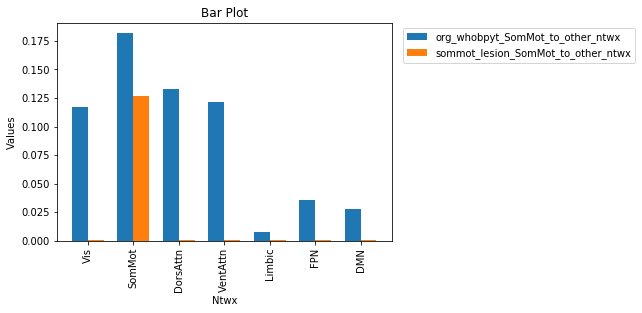

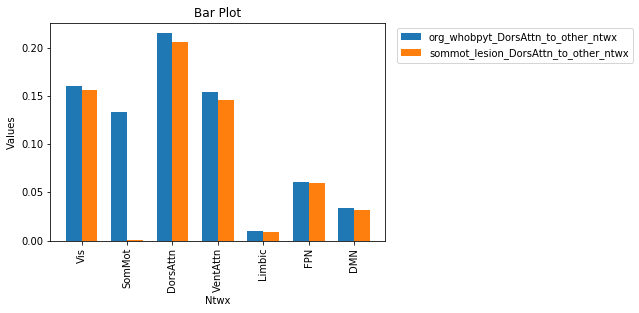

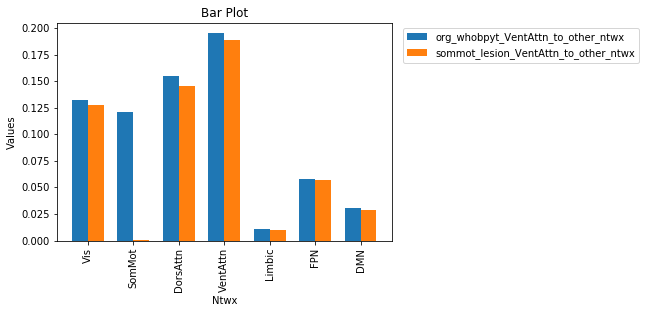

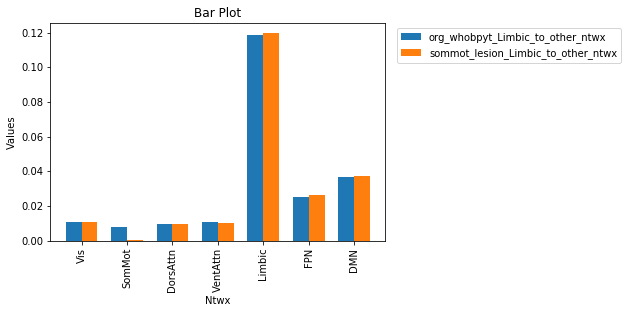

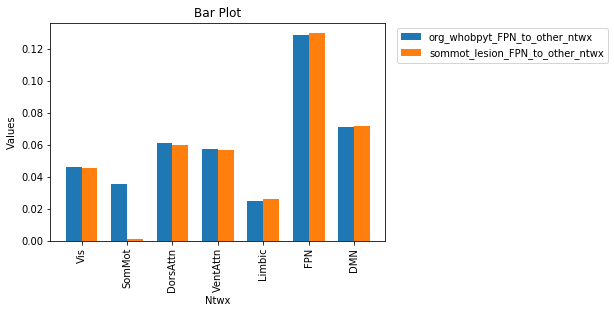

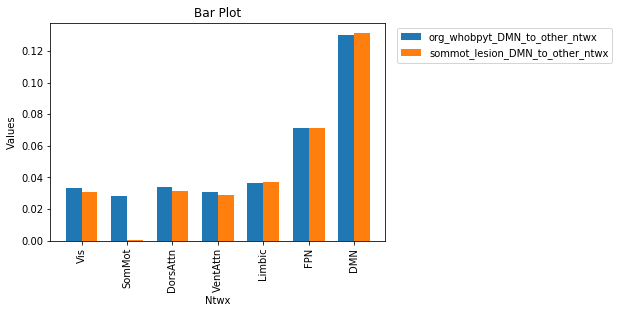

In [37]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx[j], width, label='sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DAN

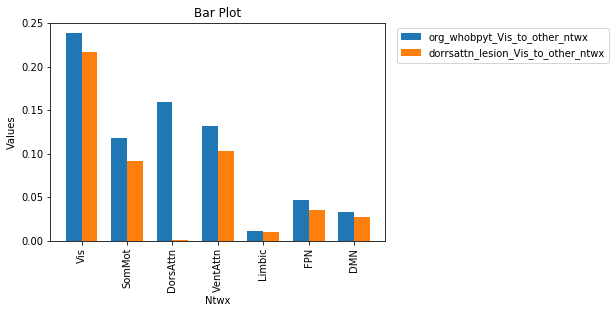

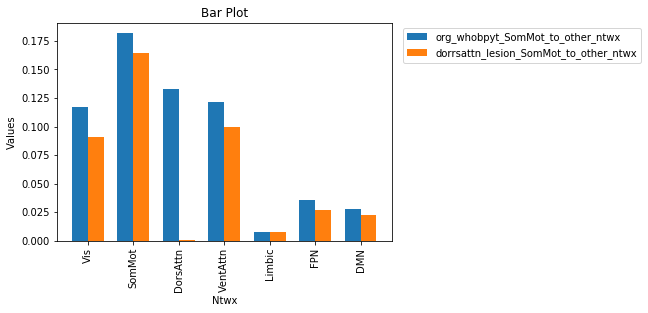

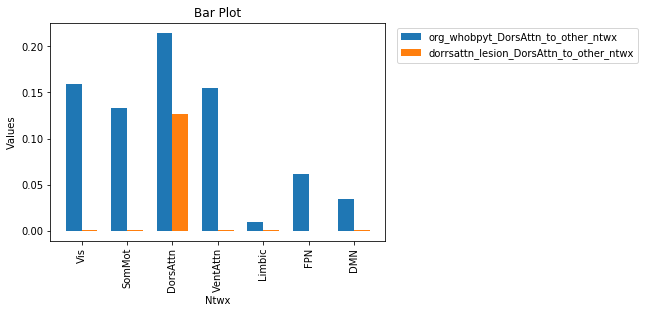

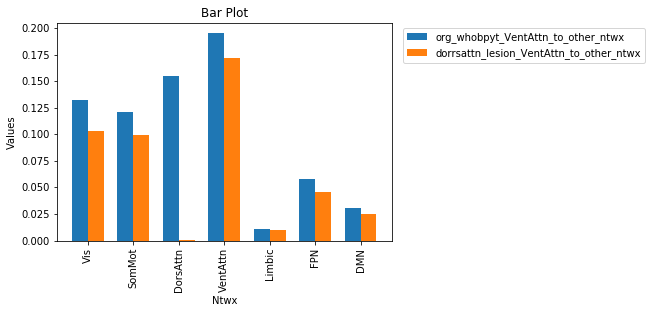

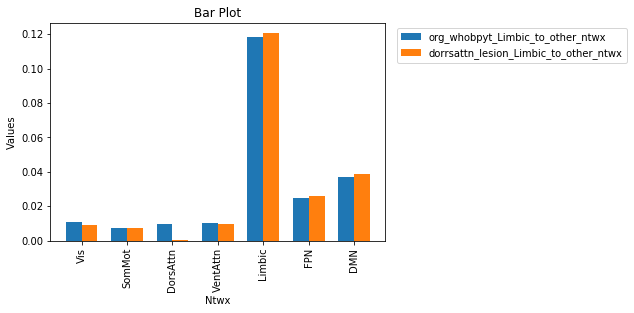

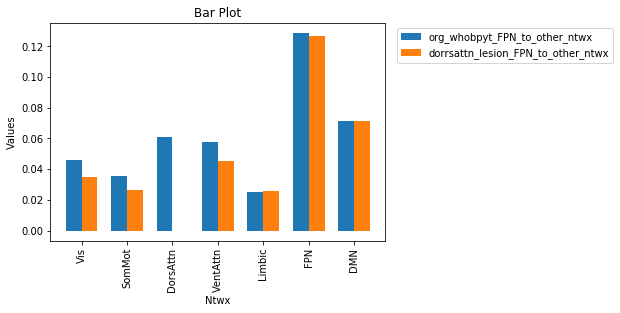

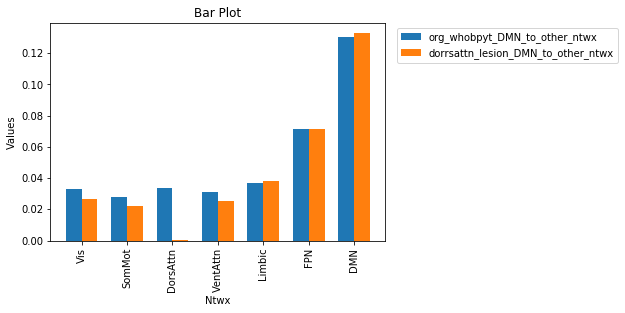

In [38]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx[j], width, label='dorrsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VAN

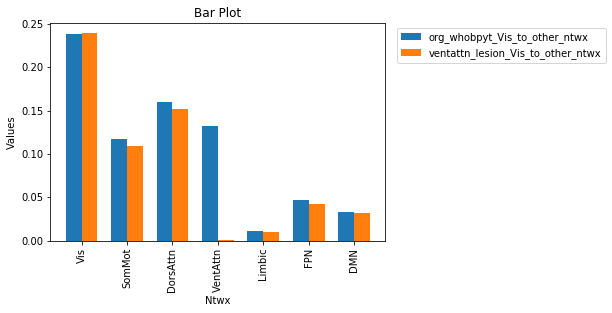

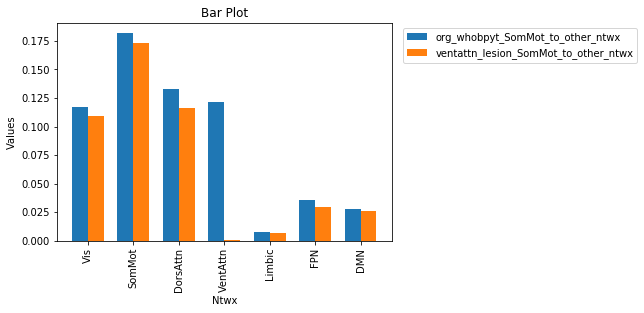

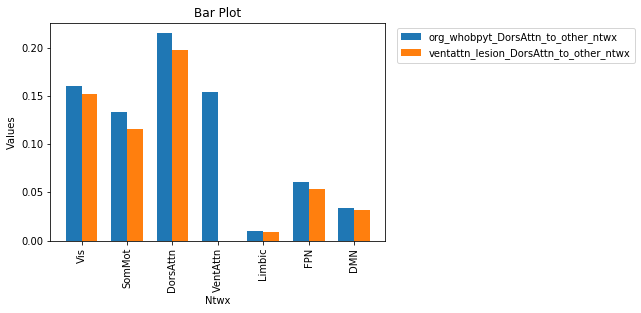

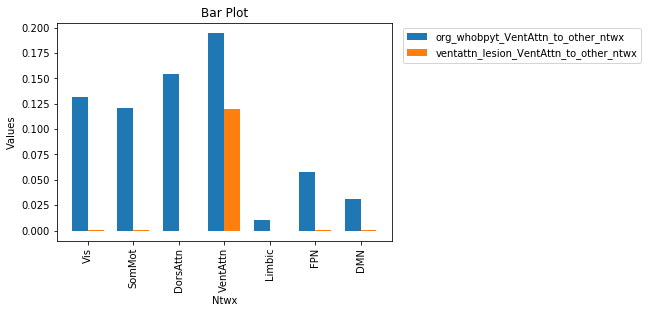

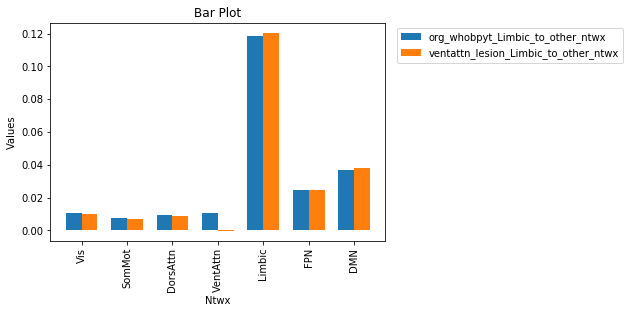

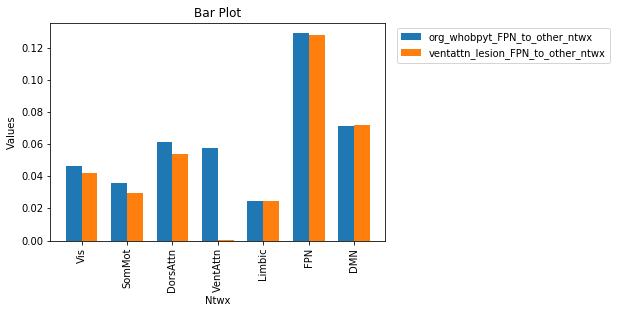

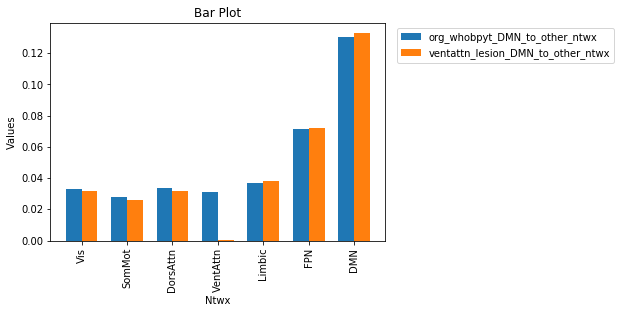

In [39]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx[j], width, label='ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

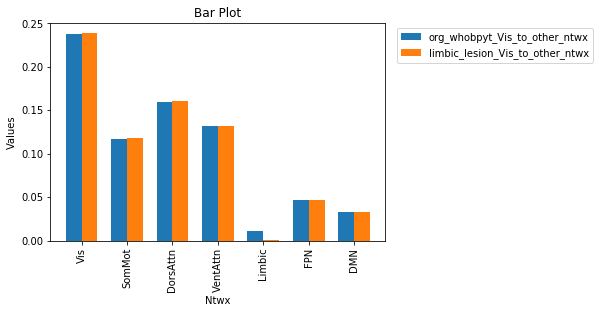

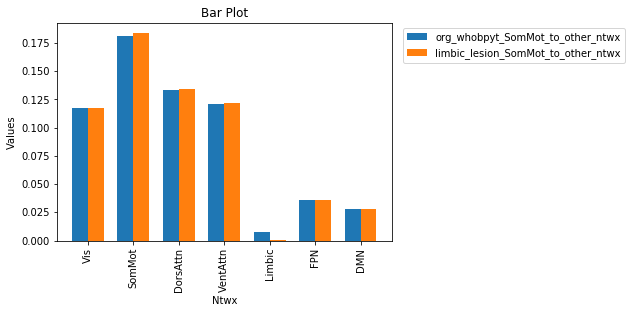

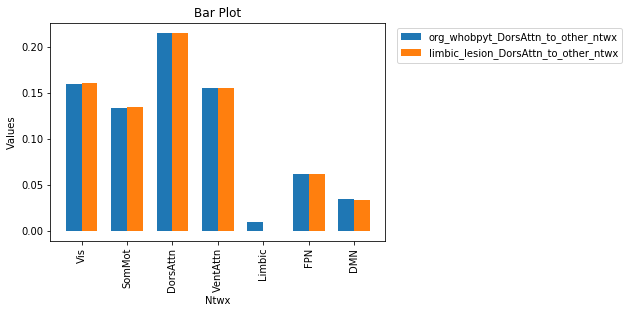

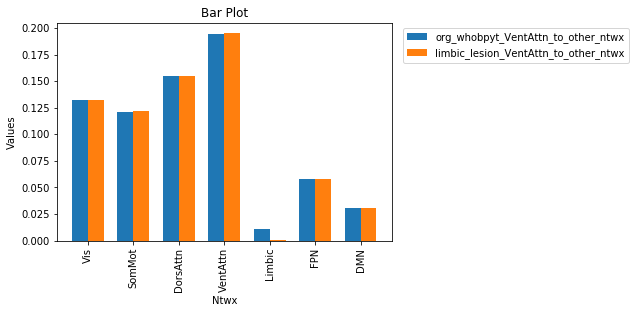

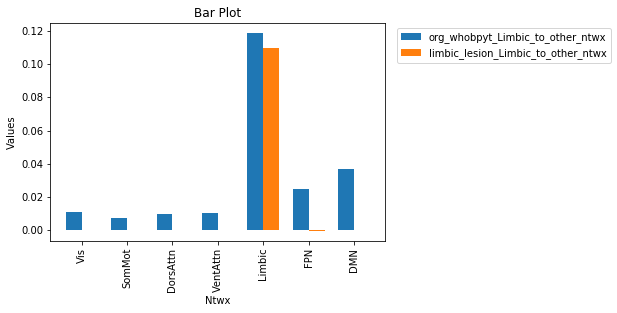

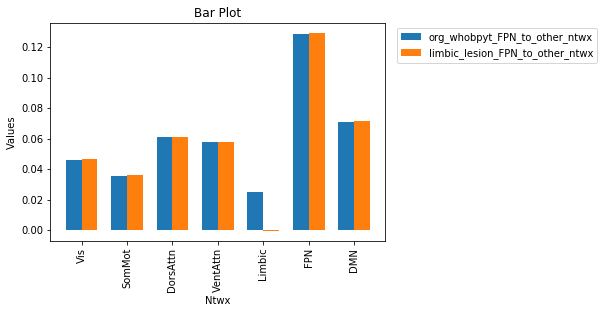

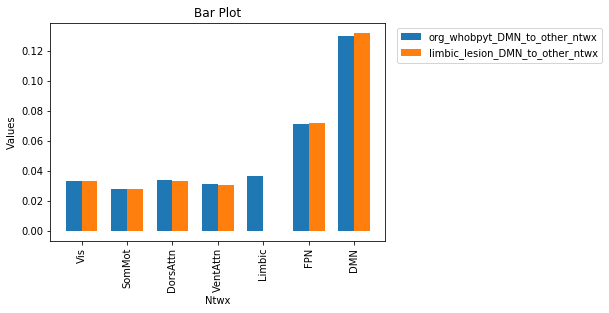

In [40]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx[j], width, label='limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

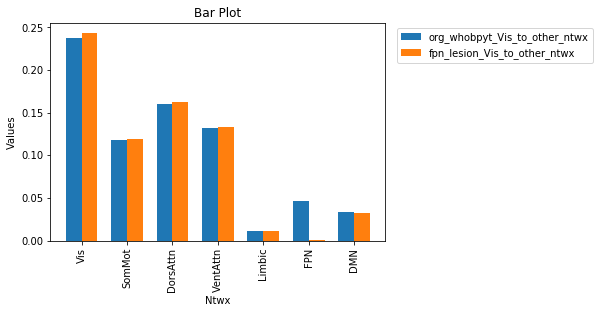

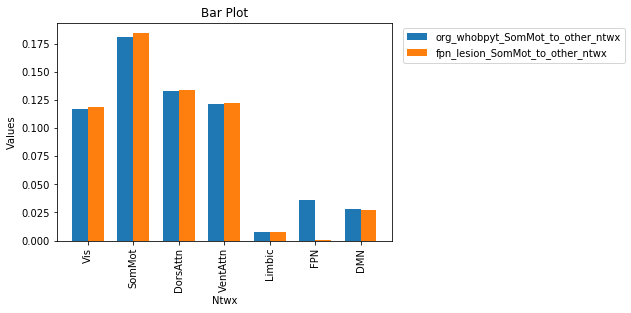

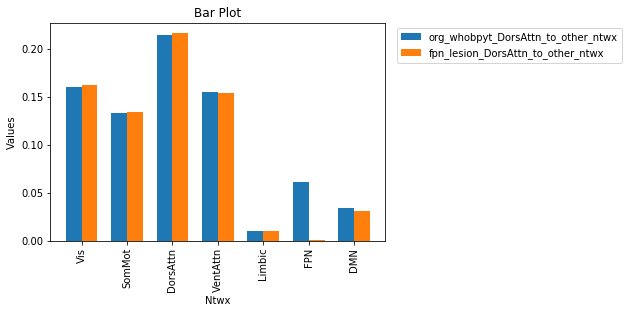

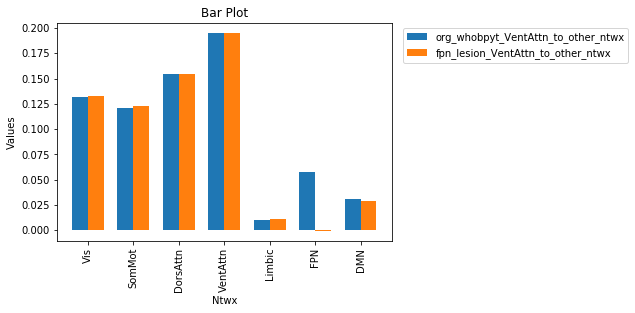

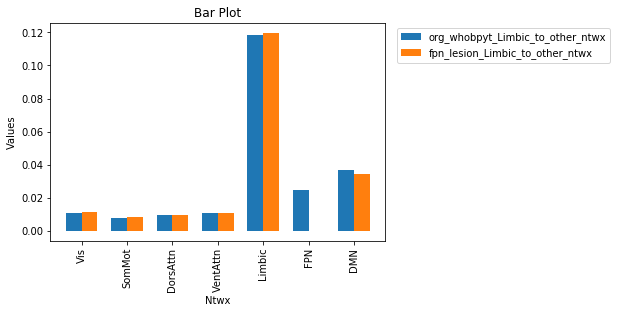

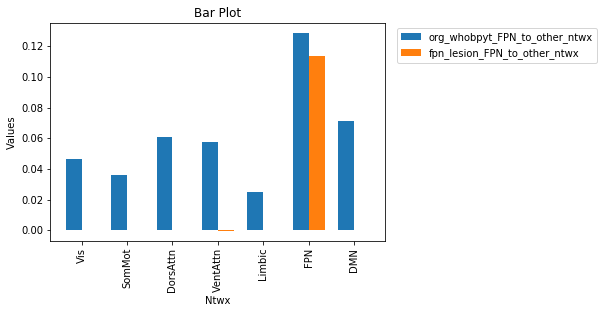

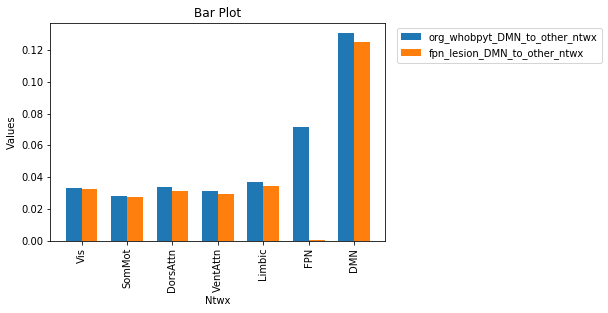

In [41]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx[j], width, label='fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

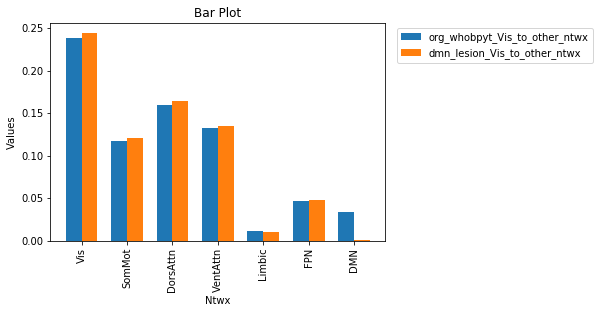

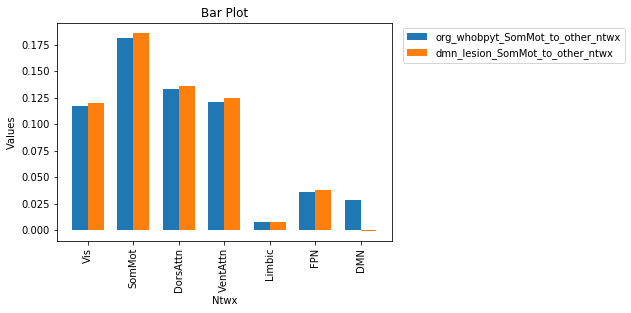

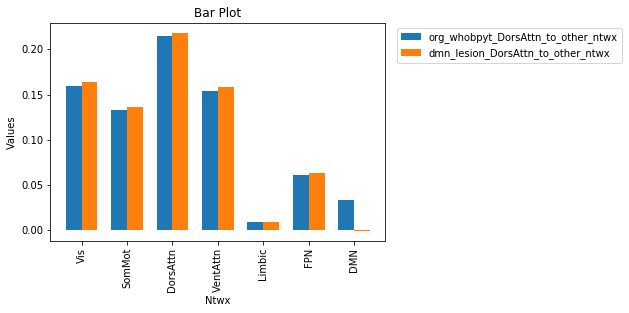

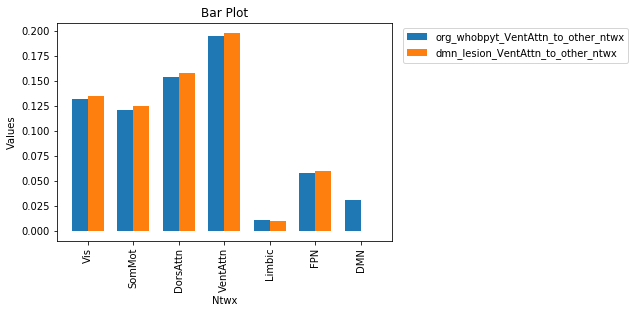

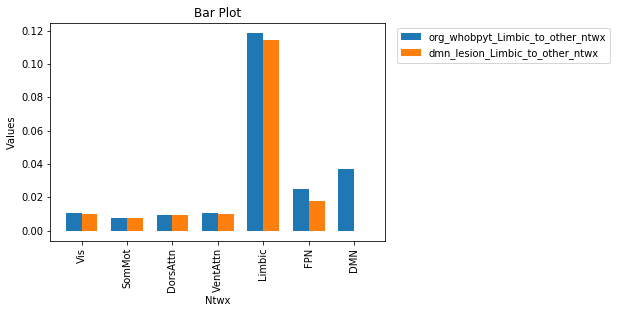

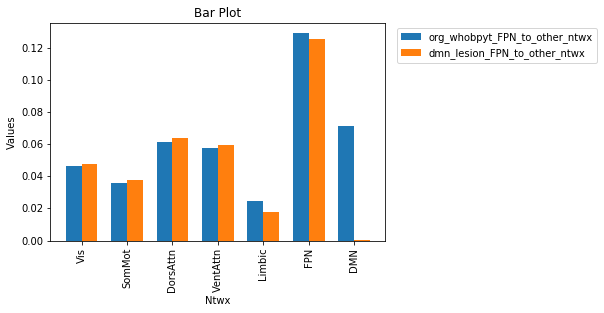

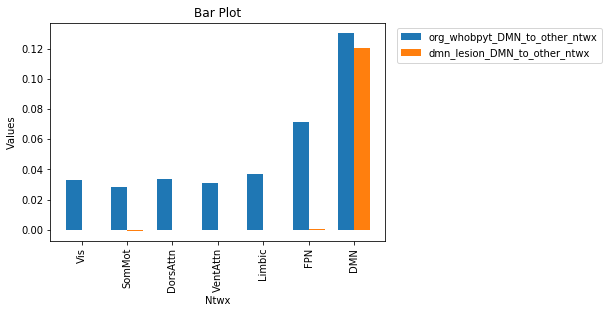

In [42]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx[j], width, label='dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

# End of Part one

#  --------------------------------------------------------------------------------------------------------------

## Negative correlation counts

In [84]:
test_fc = all_subs_og_whobpyt[44].copy()

In [96]:
# sns.heatmap(all_subs_emp_fc_mat[44]<0,cmap='RdBu_r',center=0,vmax=0.9)

In [95]:
# sns.heatmap(all_subs_og_whobpyt[44]<0,cmap='RdBu_r',center=0,vmax=0.5)

In [92]:
neg_test_fc = (test_fc<0).astype(int)

In [93]:
neg_test_fc.sum()

14212

In [94]:
np.count_nonzero(neg_test_fc)

14212

In [157]:
def get_neg_fc_counts(fc):
    neg_test_fc1 = (fc<-0.05).astype(int)
    neg_counts = np.count_nonzero(neg_test_fc1)
    return neg_counts

In [158]:
get_neg_fc_counts(all_subs_emp_fc_mat[50])

4296

In [159]:
get_neg_fc_counts(all_subs_og_whobpyt[50])

1516

In [160]:
def outer_ntwx_only_fc_neg_counts(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    neg_corrs_count_lh_ntwx_to_lh_vis = get_neg_fc_counts(lh_ntwx_to_lh_vis)
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    neg_corrs_count_lh_ntwx_to_rh_vis = get_neg_fc_counts(lh_ntwx_to_rh_vis)
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    neg_corrs_count_lh_ntwx_to_lh_sommot = get_neg_fc_counts(lh_ntwx_to_lh_sommot)
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    neg_corrs_count_lh_ntwx_to_rh_sommot = get_neg_fc_counts(lh_ntwx_to_rh_sommot)
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    neg_corrs_count_lh_ntwx_to_lh_dorsattn = get_neg_fc_counts(lh_ntwx_to_lh_dorsattn)
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    neg_corrs_count_lh_ntwx_to_rh_dorsattn = get_neg_fc_counts(lh_ntwx_to_rh_dorsattn)
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    neg_corrs_count_lh_ntwx_to_lh_ventattn = get_neg_fc_counts(lh_ntwx_to_lh_ventattn)
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    neg_corrs_count_lh_ntwx_to_rh_ventattn = get_neg_fc_counts(lh_ntwx_to_rh_ventattn)
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    neg_corrs_count_lh_ntwx_to_lh_limbic = get_neg_fc_counts(lh_ntwx_to_lh_limbic)
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    neg_corrs_count_lh_ntwx_to_rh_limbic = get_neg_fc_counts(lh_ntwx_to_rh_limbic)
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    neg_corrs_count_lh_ntwx_to_lh_fpn = get_neg_fc_counts(lh_ntwx_to_lh_fpn)
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    neg_corrs_count_lh_ntwx_to_rh_fpn = get_neg_fc_counts(lh_ntwx_to_rh_fpn)
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    neg_corrs_count_lh_ntwx_to_lh_dmn = get_neg_fc_counts(lh_ntwx_to_lh_dmn)
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    neg_corrs_count_lh_ntwx_to_rh_dmn = get_neg_fc_counts(lh_ntwx_to_rh_dmn)
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    neg_corrs_count_rh_ntwx_to_lh_vis = get_neg_fc_counts(rh_ntwx_to_lh_vis)
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    neg_corrs_count_rh_ntwx_to_rh_vis = get_neg_fc_counts(rh_ntwx_to_rh_vis)
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    neg_corrs_count_rh_ntwx_to_lh_sommot = get_neg_fc_counts(rh_ntwx_to_lh_sommot)
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    neg_corrs_count_rh_ntwx_to_rh_sommot = get_neg_fc_counts(rh_ntwx_to_rh_sommot)
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    neg_corrs_count_rh_ntwx_to_lh_dorsattn = get_neg_fc_counts(rh_ntwx_to_lh_dorsattn)
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    neg_corrs_count_rh_ntwx_to_rh_dorsattn = get_neg_fc_counts(rh_ntwx_to_rh_dorsattn)
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    neg_corrs_count_rh_ntwx_to_lh_ventattn = get_neg_fc_counts(rh_ntwx_to_lh_ventattn)
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    neg_corrs_count_rh_ntwx_to_rh_ventattn = get_neg_fc_counts(rh_ntwx_to_rh_ventattn)
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    neg_corrs_count_rh_ntwx_to_lh_limbic = get_neg_fc_counts(rh_ntwx_to_lh_limbic)
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    neg_corrs_count_rh_ntwx_to_rh_limbic = get_neg_fc_counts(rh_ntwx_to_rh_limbic)
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    neg_corrs_count_rh_ntwx_to_lh_fpn = get_neg_fc_counts(rh_ntwx_to_lh_fpn)
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    neg_corrs_count_rh_ntwx_to_rh_fpn = get_neg_fc_counts(rh_ntwx_to_rh_fpn)
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    neg_corrs_count_rh_ntwx_to_lh_dmn = get_neg_fc_counts(rh_ntwx_to_lh_dmn)
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
    neg_corrs_count_rh_ntwx_to_rh_dmn = get_neg_fc_counts(rh_ntwx_to_rh_dmn)
        
    neg_corrs_count_mean_ntwx_to_vis_fc = np.mean(neg_corrs_count_lh_ntwx_to_lh_vis + (neg_corrs_count_lh_ntwx_to_rh_vis + neg_corrs_count_rh_ntwx_to_lh_vis)/2 + neg_corrs_count_rh_ntwx_to_rh_vis)
    neg_corrs_count_mean_ntwx_to_sommot_fc = np.mean(neg_corrs_count_lh_ntwx_to_lh_sommot + (neg_corrs_count_lh_ntwx_to_rh_sommot + neg_corrs_count_rh_ntwx_to_lh_sommot)/2 + neg_corrs_count_rh_ntwx_to_rh_sommot)
    neg_corrs_count_mean_ntwx_to_dorsattn_fc = np.mean(neg_corrs_count_lh_ntwx_to_lh_dorsattn + (neg_corrs_count_lh_ntwx_to_rh_dorsattn + neg_corrs_count_rh_ntwx_to_lh_dorsattn)/2 + neg_corrs_count_rh_ntwx_to_rh_dorsattn)
    neg_corrs_count_mean_ntwx_to_ventattn_fc = np.mean(neg_corrs_count_lh_ntwx_to_lh_ventattn + (neg_corrs_count_lh_ntwx_to_rh_ventattn + neg_corrs_count_rh_ntwx_to_lh_ventattn)/2 + neg_corrs_count_rh_ntwx_to_rh_ventattn)
    neg_corrs_count_mean_ntwx_to_limbic_fc = np.mean(neg_corrs_count_lh_ntwx_to_lh_limbic + (neg_corrs_count_lh_ntwx_to_rh_limbic + neg_corrs_count_rh_ntwx_to_lh_limbic)/2 + neg_corrs_count_rh_ntwx_to_rh_limbic)
    neg_corrs_count_mean_ntwx_to_fpn_fc = np.mean(neg_corrs_count_lh_ntwx_to_lh_fpn + (neg_corrs_count_lh_ntwx_to_rh_fpn + neg_corrs_count_rh_ntwx_to_lh_fpn)/2 + neg_corrs_count_rh_ntwx_to_rh_fpn)
    neg_corrs_count_mean_ntwx_to_dmn_fc = np.mean(neg_corrs_count_lh_ntwx_to_lh_dmn + (neg_corrs_count_lh_ntwx_to_rh_dmn + neg_corrs_count_rh_ntwx_to_lh_dmn)/2 + neg_corrs_count_rh_ntwx_to_rh_dmn)
    
    
    return neg_corrs_count_mean_ntwx_to_vis_fc,neg_corrs_count_mean_ntwx_to_sommot_fc,neg_corrs_count_mean_ntwx_to_dorsattn_fc,neg_corrs_count_mean_ntwx_to_ventattn_fc,neg_corrs_count_mean_ntwx_to_limbic_fc,neg_corrs_count_mean_ntwx_to_fpn_fc,neg_corrs_count_mean_ntwx_to_dmn_fc

### og whobpyt

In [161]:
%%time

neg_counts_all_subs_vis_to_other_ntwx = []
neg_counts_all_subs_sommot_to_other_ntwx = []
neg_counts_all_subs_dorsattn_to_other_ntwx = []
neg_counts_all_subs_ventattn_to_other_ntwx = []
neg_counts_all_subs_limbic_to_other_ntwx = []
neg_counts_all_subs_fpn_to_other_ntwx = []
neg_counts_all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(all_subs_og_whobpyt,i,0)
    neg_counts_all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(all_subs_og_whobpyt,i,1)
    neg_counts_all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(all_subs_og_whobpyt,i,2)
    neg_counts_all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(all_subs_og_whobpyt,i,3)
    neg_counts_all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(all_subs_og_whobpyt,i,4)
    neg_counts_all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(all_subs_og_whobpyt,i,5)
    neg_counts_all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(all_subs_og_whobpyt,i,6)
    neg_counts_all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 766 ms, sys: 38.2 ms, total: 804 ms
Wall time: 800 ms


In [162]:
neg_counts_og_whobpyt_vis_to_other_ntwx = np.mean(neg_counts_all_subs_vis_to_other_ntwx,axis=0)
neg_counts_og_whobpyt_sommot_to_other_ntwx = np.mean(neg_counts_all_subs_sommot_to_other_ntwx,axis=0)
neg_counts_og_whobpyt_dorsattn_to_other_ntwx = np.mean(neg_counts_all_subs_dorsattn_to_other_ntwx,axis=0)
neg_counts_og_whobpyt_ventattn_to_other_ntwx = np.mean(neg_counts_all_subs_ventattn_to_other_ntwx,axis=0)
neg_counts_og_whobpyt_limbic_to_other_ntwx = np.mean(neg_counts_all_subs_limbic_to_other_ntwx,axis=0)
neg_counts_og_whobpyt_fpn_to_other_ntwx = np.mean(neg_counts_all_subs_fpn_to_other_ntwx,axis=0)
neg_counts_og_whobpyt_dmn_to_other_ntwx = np.mean(neg_counts_all_subs_dmn_to_other_ntwx,axis=0)

In [163]:
neg_counts_outer_to_other_ntwx = [neg_counts_og_whobpyt_vis_to_other_ntwx,neg_counts_og_whobpyt_sommot_to_other_ntwx,
                                  neg_counts_og_whobpyt_dorsattn_to_other_ntwx,neg_counts_og_whobpyt_ventattn_to_other_ntwx,
                                  neg_counts_og_whobpyt_limbic_to_other_ntwx,neg_counts_og_whobpyt_fpn_to_other_ntwx,
                                  neg_counts_og_whobpyt_dmn_to_other_ntwx]

In [164]:
neg_counts_og_whobpyt_outer_to_other_ntwx = neg_counts_outer_to_other_ntwx.copy()

### Lesion whobpyt

In [165]:
def get_outer_ntwx_fc_neg_counts(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_neg_counts(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [166]:
vis_lesion_vis_to_other_ntwx_neg, vis_lesion_sommot_to_other_ntwx_neg, vis_lesion_dorsattn_to_other_ntwx_neg, vis_lesion_ventattn_to_other_ntwx_neg, vis_lesion_limbic_to_other_ntwx_neg, vis_lesion_fpn_to_other_ntwx_neg, vis_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg_counts(all_subs_vis_lesion)
sommot_lesion_vis_to_other_ntwx_neg, sommot_lesion_sommot_to_other_ntwx_neg, sommot_lesion_dorsattn_to_other_ntwx_neg, sommot_lesion_ventattn_to_other_ntwx_neg, sommot_lesion_limbic_to_other_ntwx_neg, sommot_lesion_fpn_to_other_ntwx_neg, sommot_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg_counts(all_subs_sommot_lesion)
dorsattn_lesion_vis_to_other_ntwx_neg, dorsattn_lesion_sommot_to_other_ntwx_neg, dorsattn_lesion_dorsattn_to_other_ntwx_neg, dorsattn_lesion_ventattn_to_other_ntwx_neg, dorsattn_lesion_limbic_to_other_ntwx_neg, dorsattn_lesion_fpn_to_other_ntwx_neg, dorsattn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg_counts(all_subs_dorsattn_lesion)
ventattn_lesion_vis_to_other_ntwx_neg, ventattn_lesion_sommot_to_other_ntwx_neg, ventattn_lesion_dorsattn_to_other_ntwx_neg, ventattn_lesion_ventattn_to_other_ntwx_neg, ventattn_lesion_limbic_to_other_ntwx_neg, ventattn_lesion_fpn_to_other_ntwx_neg, ventattn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg_counts(all_subs_ventattn_lesion)
limbic_lesion_vis_to_other_ntwx_neg, limbic_lesion_sommot_to_other_ntwx_neg, limbic_lesion_dorsattn_to_other_ntwx_neg, limbic_lesion_ventattn_to_other_ntwx_neg, limbic_lesion_limbic_to_other_ntwx_neg, limbic_lesion_fpn_to_other_ntwx_neg, limbic_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg_counts(all_subs_limbic_lesion)
fpn_lesion_vis_to_other_ntwx_neg, fpn_lesion_sommot_to_other_ntwx_neg, fpn_lesion_dorsattn_to_other_ntwx_neg, fpn_lesion_ventattn_to_other_ntwx_neg, fpn_lesion_limbic_to_other_ntwx_neg, fpn_lesion_fpn_to_other_ntwx_neg, fpn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg_counts(all_subs_fpn_lesion)
dmn_lesion_vis_to_other_ntwx_neg, dmn_lesion_sommot_to_other_ntwx_neg, dmn_lesion_dorsattn_to_other_ntwx_neg, dmn_lesion_ventattn_to_other_ntwx_neg, dmn_lesion_limbic_to_other_ntwx_neg, dmn_lesion_fpn_to_other_ntwx_neg, dmn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg_counts(all_subs_dmn_lesion)

In [167]:
vis_lesion_outer_to_other_ntwx_neg = [vis_lesion_vis_to_other_ntwx_neg, vis_lesion_sommot_to_other_ntwx_neg, vis_lesion_dorsattn_to_other_ntwx_neg, vis_lesion_ventattn_to_other_ntwx_neg, vis_lesion_limbic_to_other_ntwx_neg, vis_lesion_fpn_to_other_ntwx_neg, vis_lesion_dmn_to_other_ntwx_neg]
sommot_lesion_outer_to_other_ntwx_neg = [sommot_lesion_vis_to_other_ntwx_neg, sommot_lesion_sommot_to_other_ntwx_neg, sommot_lesion_dorsattn_to_other_ntwx_neg, sommot_lesion_ventattn_to_other_ntwx_neg, sommot_lesion_limbic_to_other_ntwx_neg, sommot_lesion_fpn_to_other_ntwx_neg, sommot_lesion_dmn_to_other_ntwx_neg]
dorsattn_lesion_outer_to_other_ntwx_neg = [dorsattn_lesion_vis_to_other_ntwx_neg, dorsattn_lesion_sommot_to_other_ntwx_neg, dorsattn_lesion_dorsattn_to_other_ntwx_neg, dorsattn_lesion_ventattn_to_other_ntwx_neg, dorsattn_lesion_limbic_to_other_ntwx_neg, dorsattn_lesion_fpn_to_other_ntwx_neg, dorsattn_lesion_dmn_to_other_ntwx_neg]
ventattn_lesion_outer_to_other_ntwx_neg = [ventattn_lesion_vis_to_other_ntwx_neg, ventattn_lesion_sommot_to_other_ntwx_neg, ventattn_lesion_dorsattn_to_other_ntwx_neg, ventattn_lesion_ventattn_to_other_ntwx_neg, ventattn_lesion_limbic_to_other_ntwx_neg, ventattn_lesion_fpn_to_other_ntwx_neg, ventattn_lesion_dmn_to_other_ntwx_neg]
limbic_lesion_outer_to_other_ntwx_neg = [limbic_lesion_vis_to_other_ntwx_neg, limbic_lesion_sommot_to_other_ntwx_neg, limbic_lesion_dorsattn_to_other_ntwx_neg, limbic_lesion_ventattn_to_other_ntwx_neg, limbic_lesion_limbic_to_other_ntwx_neg, limbic_lesion_fpn_to_other_ntwx_neg, limbic_lesion_dmn_to_other_ntwx_neg]
fpn_lesion_outer_to_other_ntwx_neg = [fpn_lesion_vis_to_other_ntwx_neg, fpn_lesion_sommot_to_other_ntwx_neg, fpn_lesion_dorsattn_to_other_ntwx_neg, fpn_lesion_ventattn_to_other_ntwx_neg, fpn_lesion_limbic_to_other_ntwx_neg, fpn_lesion_fpn_to_other_ntwx_neg, fpn_lesion_dmn_to_other_ntwx_neg]
dmn_lesion_outer_to_other_ntwx_neg = [dmn_lesion_vis_to_other_ntwx_neg, dmn_lesion_sommot_to_other_ntwx_neg, dmn_lesion_dorsattn_to_other_ntwx_neg, dmn_lesion_ventattn_to_other_ntwx_neg, dmn_lesion_limbic_to_other_ntwx_neg, dmn_lesion_fpn_to_other_ntwx_neg, dmn_lesion_dmn_to_other_ntwx_neg]

In [168]:
neg_counts_og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in neg_counts_og_whobpyt_outer_to_other_ntwx]

vis_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx_neg]
sommot_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx_neg]
dorsattn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx_neg]
ventattn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx_neg]
limbic_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx_neg]
fpn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx_neg]
dmn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx_neg]

#### Visual

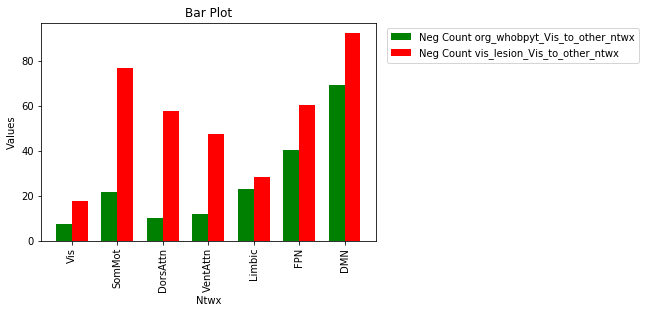

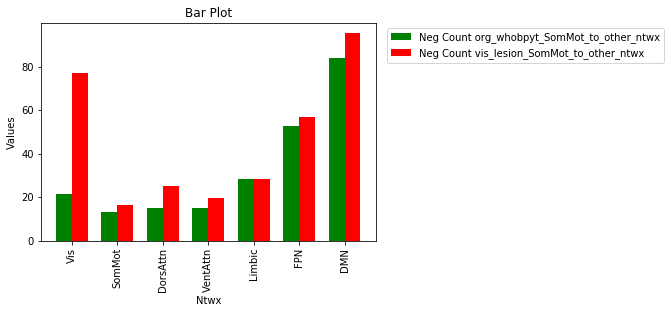

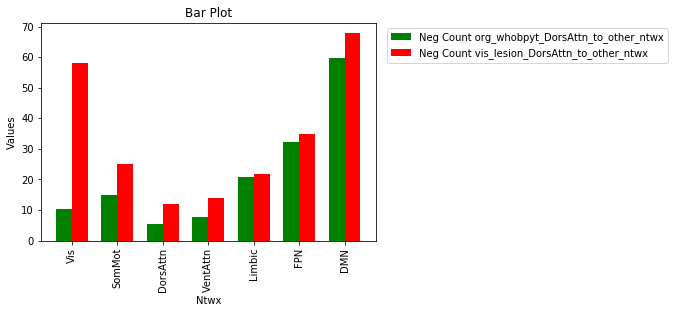

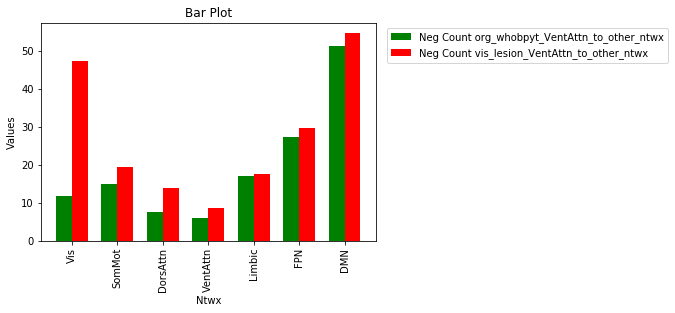

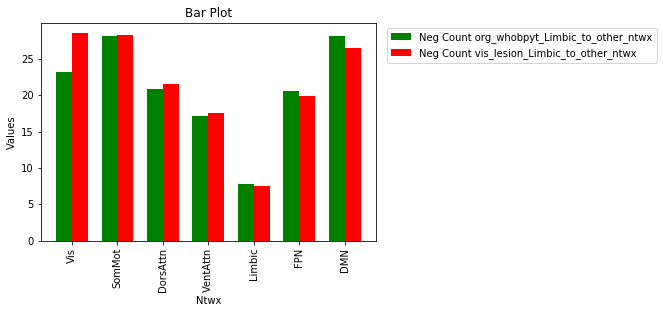

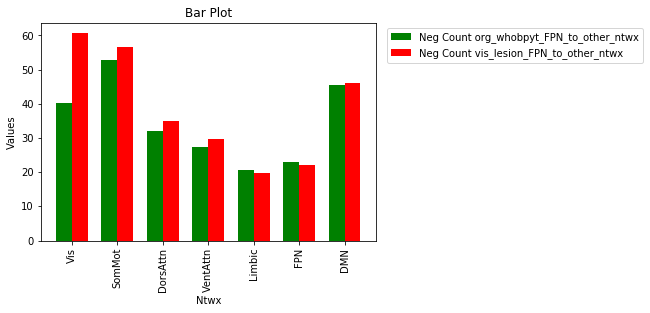

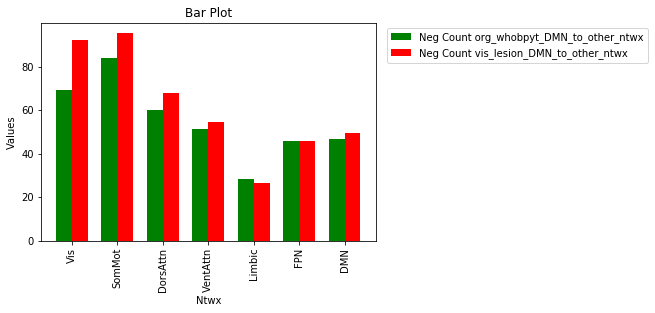

In [169]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, neg_counts_og_whobpyt_outer_to_other_ntwx[j], width, color='g', label='Neg Count org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx_neg[j], width, color='r', label='Neg Count vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

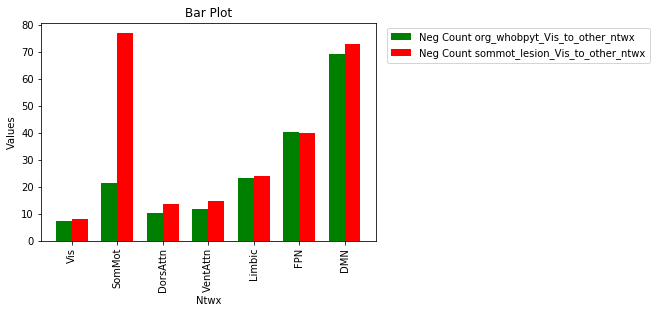

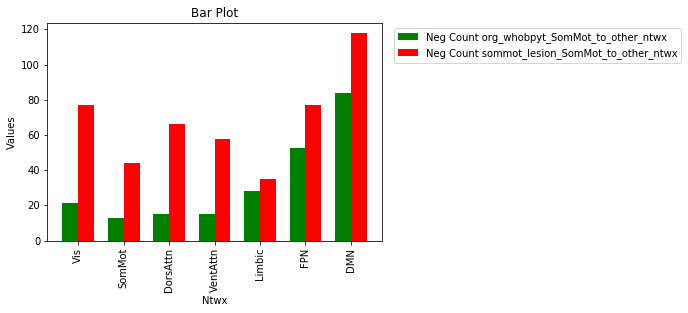

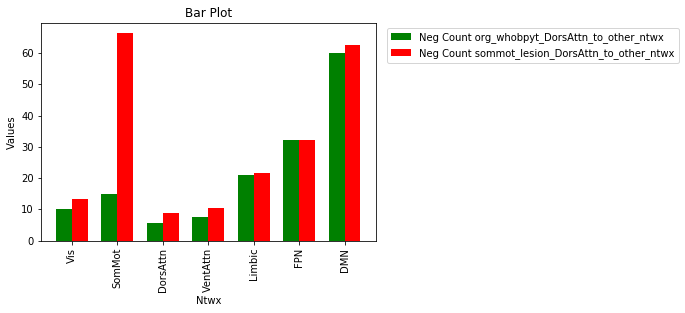

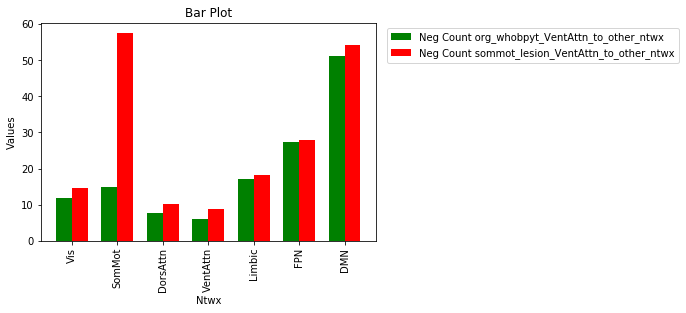

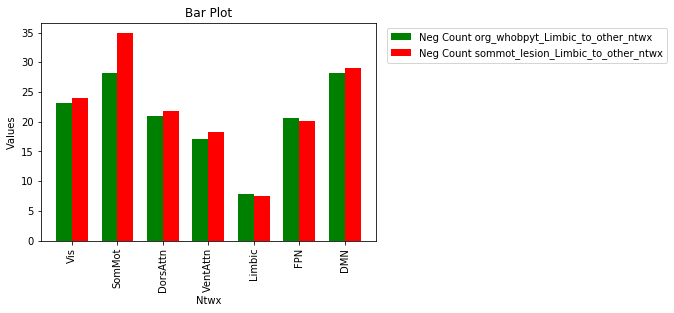

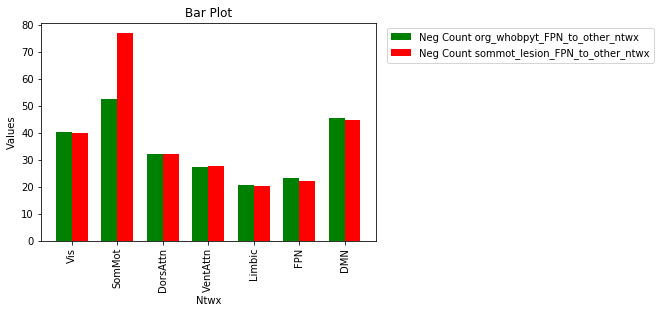

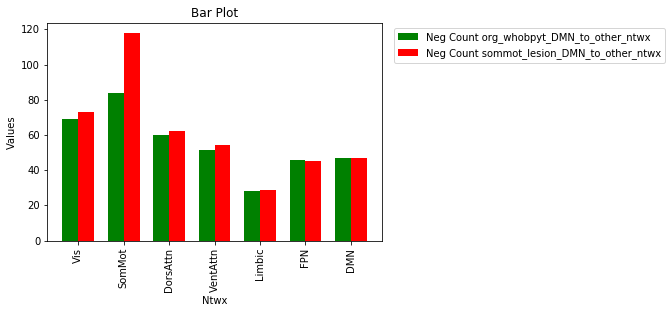

In [170]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, neg_counts_og_whobpyt_outer_to_other_ntwx[j], width, color='g', label='Neg Count org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx_neg[j], width, color='r', label='Neg Count sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DAN

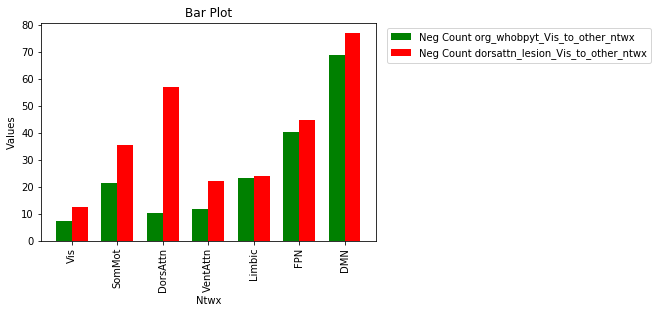

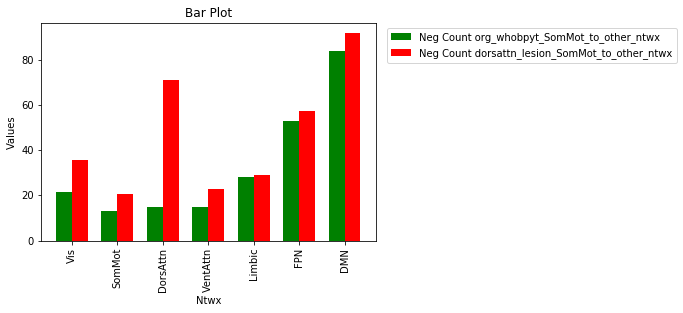

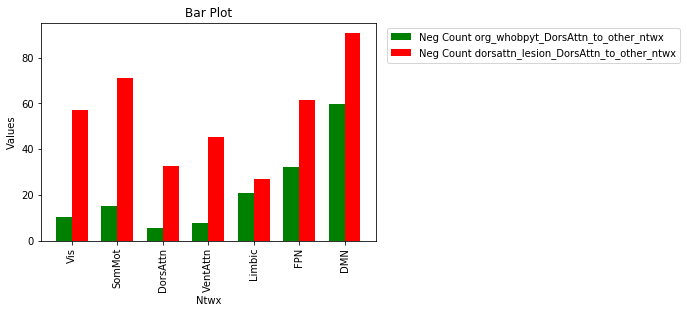

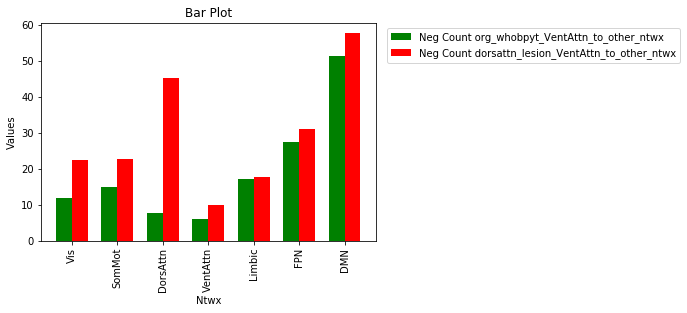

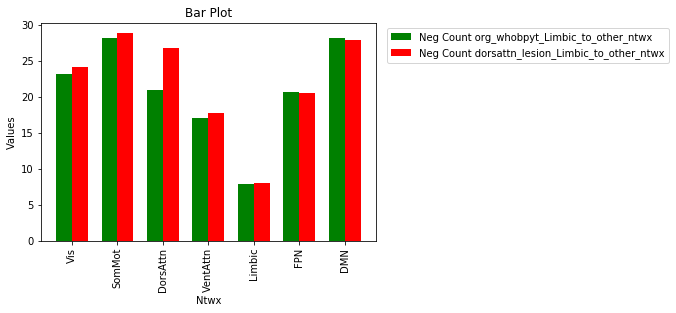

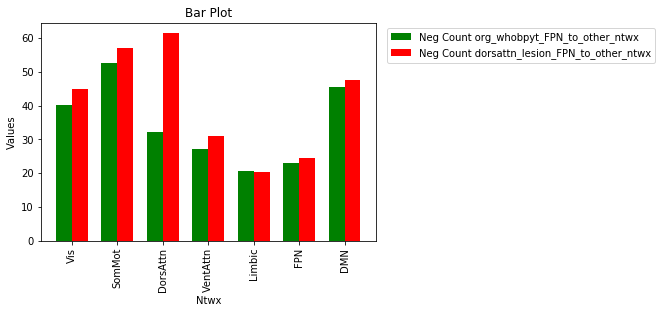

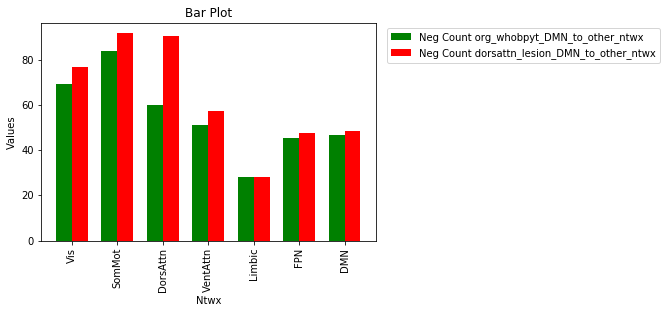

In [171]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, neg_counts_og_whobpyt_outer_to_other_ntwx[j], width, color='g', label='Neg Count org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx_neg[j], width, color='r', label='Neg Count dorsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VAN

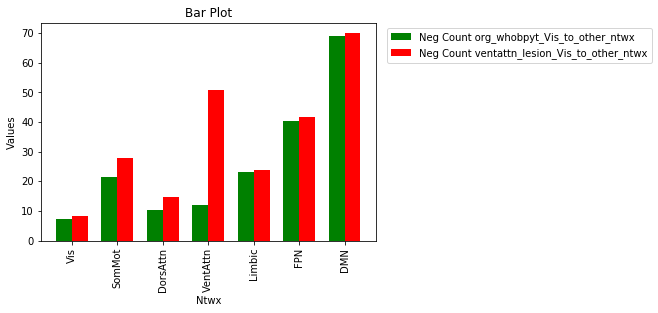

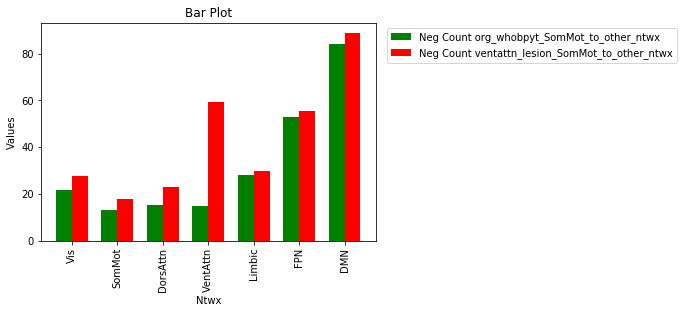

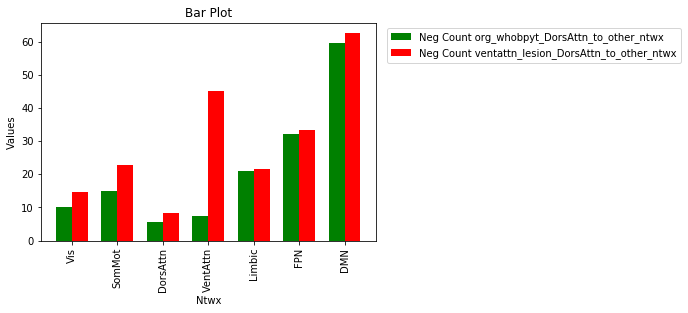

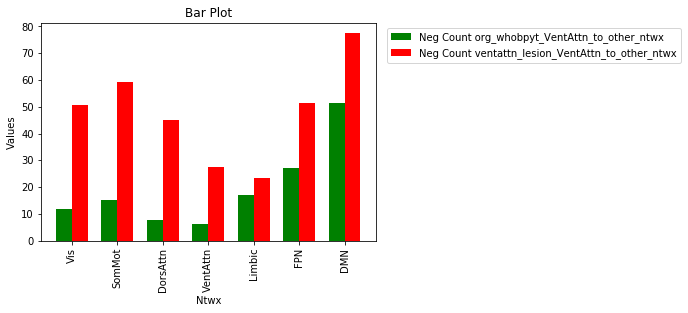

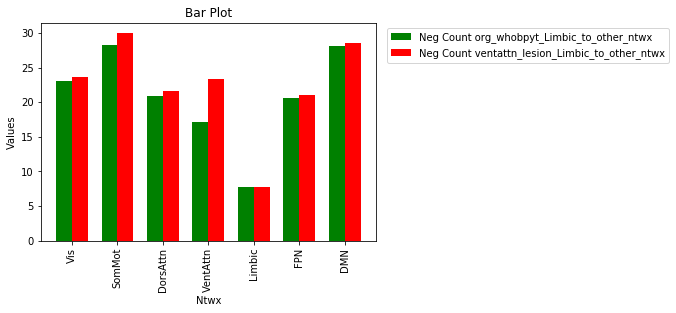

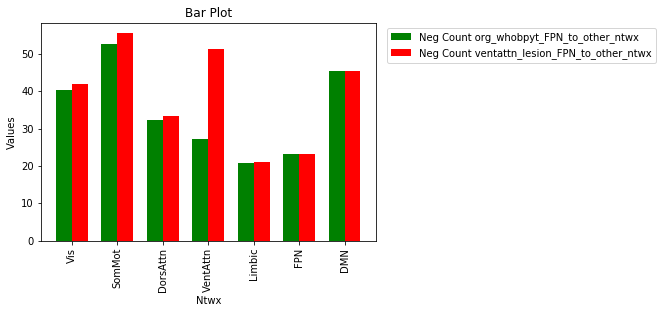

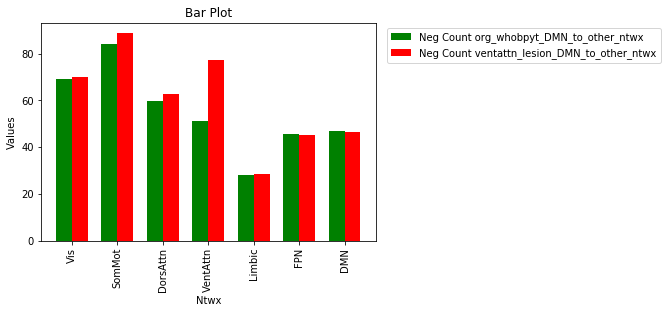

In [172]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, neg_counts_og_whobpyt_outer_to_other_ntwx[j], width, color='g', label='Neg Count org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx_neg[j], width, color='r', label='Neg Count ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

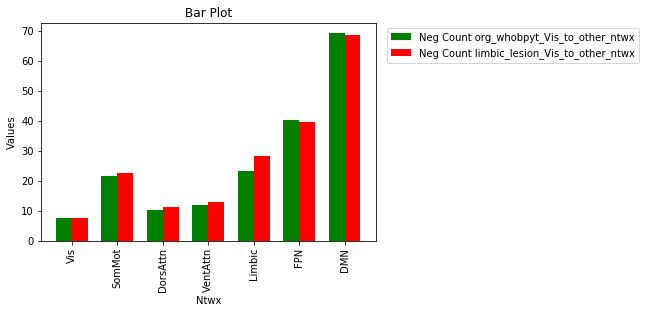

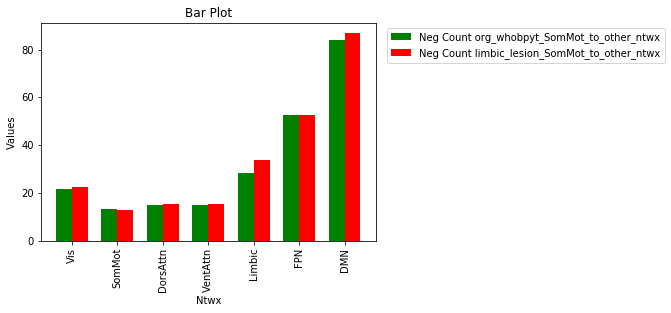

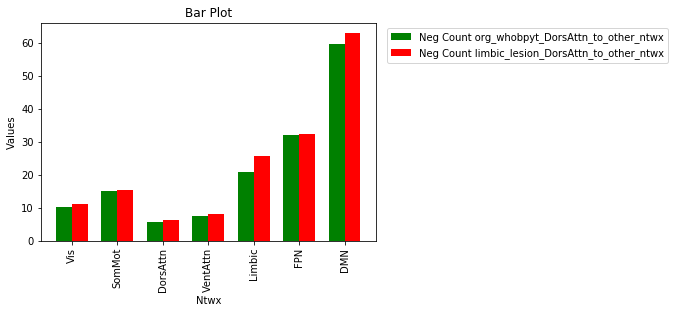

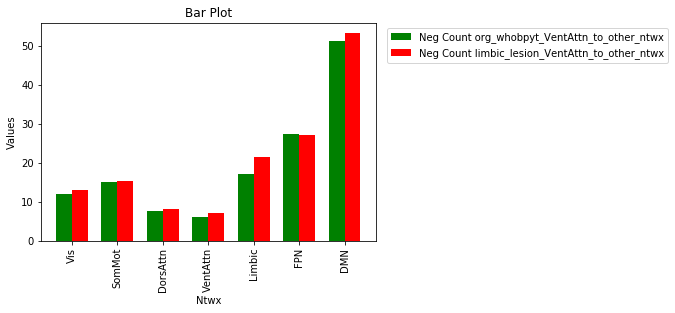

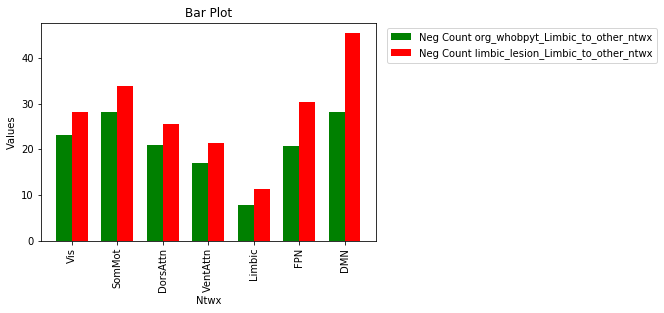

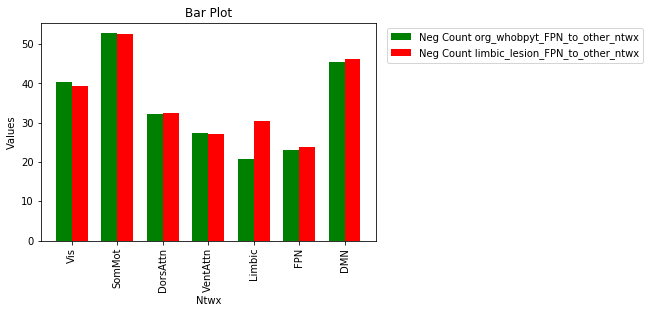

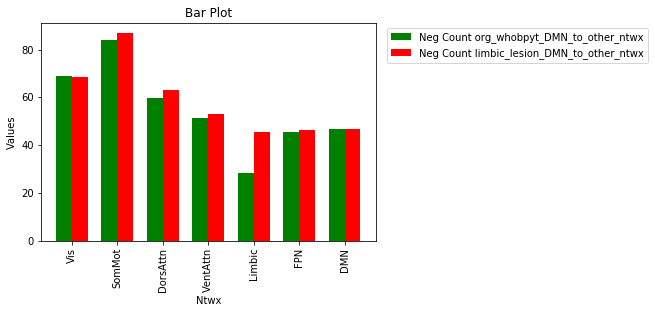

In [173]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, neg_counts_og_whobpyt_outer_to_other_ntwx[j], width, color='g', label='Neg Count org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx_neg[j], width, color='r', label='Neg Count limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

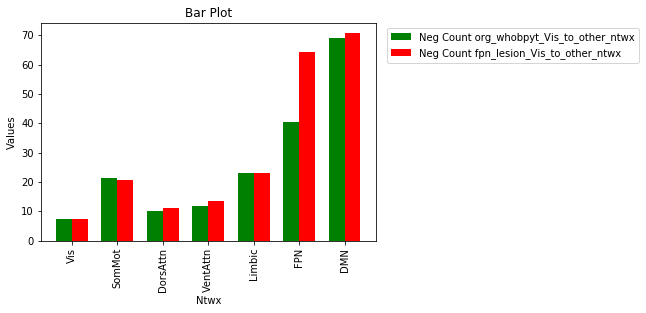

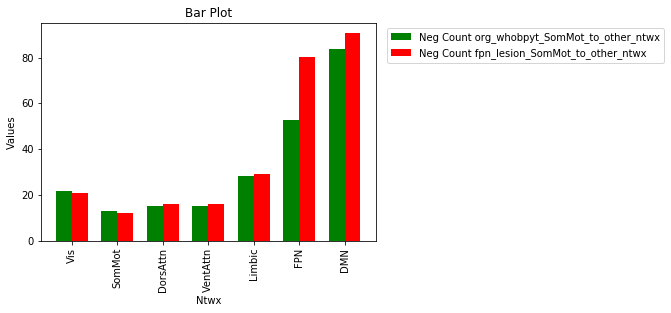

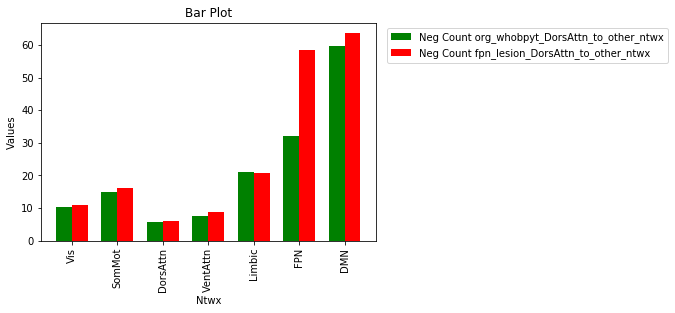

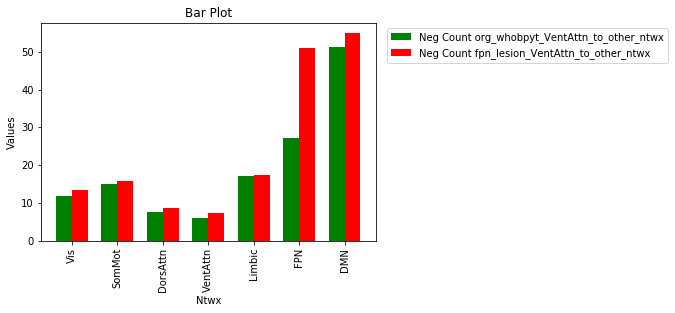

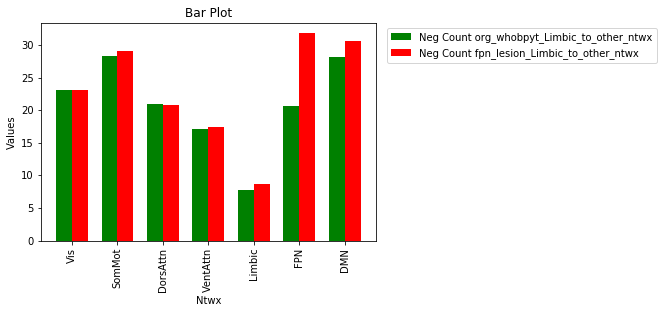

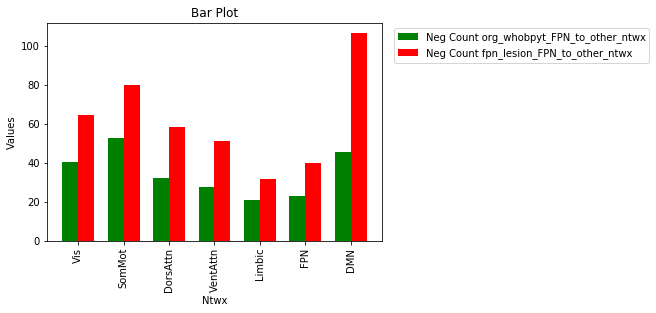

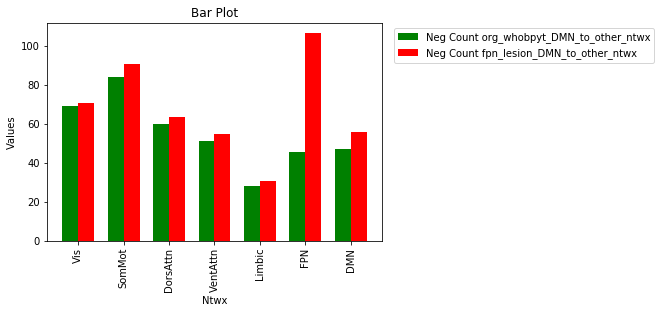

In [174]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, neg_counts_og_whobpyt_outer_to_other_ntwx[j], width, color='g', label='Neg Count org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx_neg[j], width, color='r', label='Neg Count fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

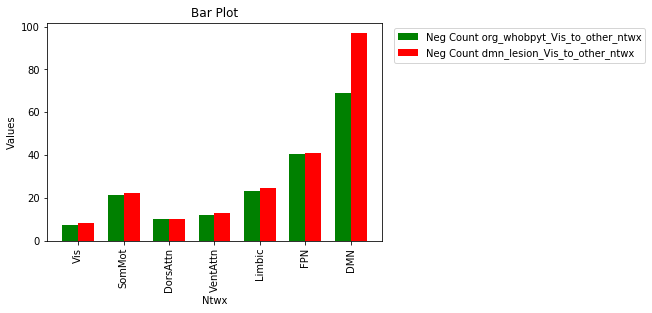

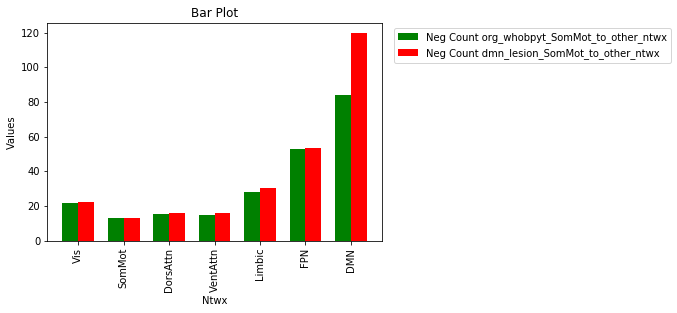

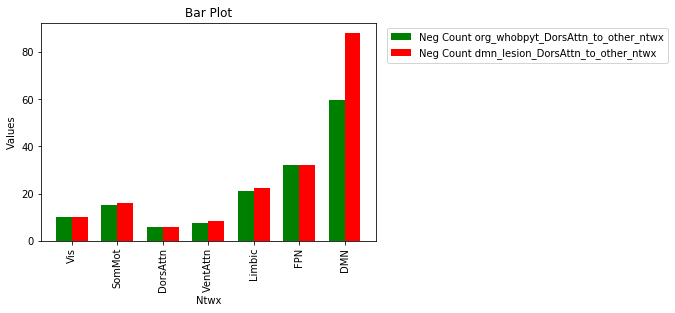

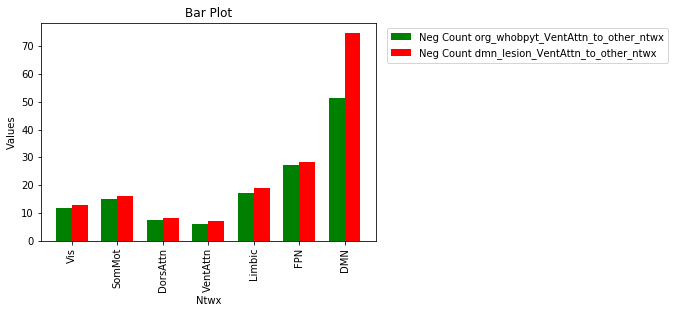

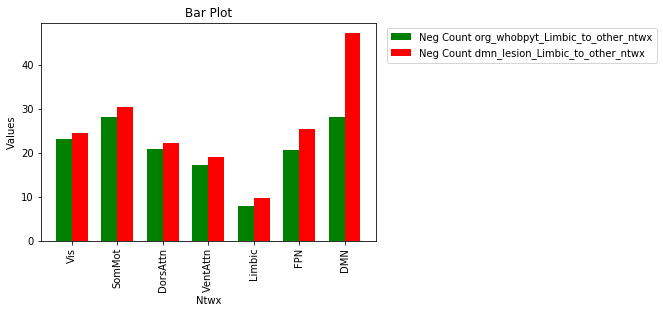

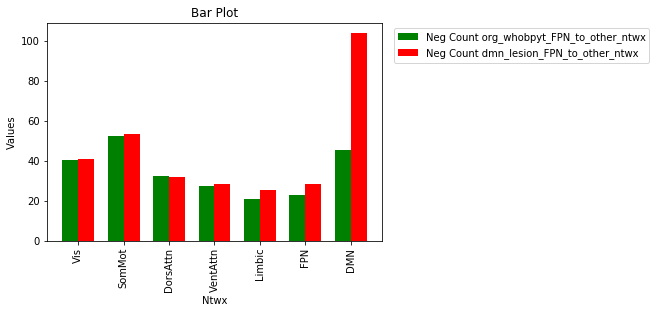

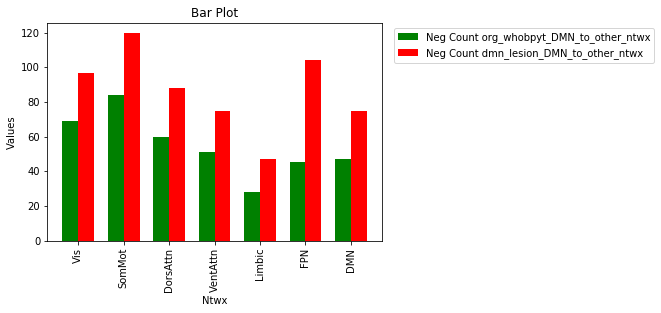

In [175]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, neg_counts_og_whobpyt_outer_to_other_ntwx[j], width, color='g', label='Neg Count org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx_neg[j], width, color='r', label='Neg Count dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### End of part 2

# ----------------------------------------------------------------------------------------------------------

### other shenanigans ...

In [176]:
import bct as bct

### FC Maps on the surface

In [180]:
g_mean = np.ones((200, 1))*(400)+np.random.randn(200, 1)
g_std = np.ones((200, 1))*(1/np.sqrt(10))+(0.05*np.random.randn(200, 1))

In [181]:
g_mean

array([[399.92718779],
       [398.11389014],
       [400.35395753],
       [400.54175866],
       [400.22173198],
       [400.07225493],
       [399.46383762],
       [400.29915544],
       [401.38879586],
       [399.82669693],
       [399.83466022],
       [398.87043455],
       [398.9694915 ],
       [400.653129  ],
       [400.60122836],
       [401.08303606],
       [400.49185176],
       [400.11182176],
       [400.03961907],
       [399.98297939],
       [398.15393678],
       [399.65277824],
       [400.96633719],
       [397.35917312],
       [400.35572776],
       [399.8366295 ],
       [399.55559032],
       [398.44195656],
       [400.42447416],
       [399.02820734],
       [399.2619959 ],
       [400.31520711],
       [400.71784958],
       [400.76421191],
       [401.14614661],
       [401.30106579],
       [399.26200044],
       [400.28790015],
       [399.38592313],
       [401.77426488],
       [399.21731885],
       [399.34330243],
       [399.08946389],
       [400

In [182]:
g_std

array([[0.34572567],
       [0.2042896 ],
       [0.2778404 ],
       [0.2802324 ],
       [0.36243458],
       [0.33524723],
       [0.30922871],
       [0.28803155],
       [0.30619596],
       [0.40601432],
       [0.38298516],
       [0.24669205],
       [0.3066371 ],
       [0.28972891],
       [0.29663199],
       [0.3069477 ],
       [0.32612592],
       [0.32946908],
       [0.29489711],
       [0.3332707 ],
       [0.30547909],
       [0.25486117],
       [0.35519221],
       [0.17838113],
       [0.28889709],
       [0.33811797],
       [0.38041511],
       [0.36597359],
       [0.43313839],
       [0.27899134],
       [0.26668136],
       [0.35862491],
       [0.32265428],
       [0.368752  ],
       [0.3178036 ],
       [0.27759726],
       [0.43506362],
       [0.25590201],
       [0.21442706],
       [0.26445608],
       [0.27304793],
       [0.33660809],
       [0.19591167],
       [0.26053724],
       [0.29644205],
       [0.35155484],
       [0.3545641 ],
       [0.315

In [183]:
# get model parameters structure and define the fitted parameters by setting non-zero variance for the model
g_mean = np.ones((200, 1))*(400)+np.random.randn(200, 1)
# g_std = np.ones((200, 1))*(1/np.sqrt(10))+(0.05*np.random.randn(200, 1))

g_EE_mean = np.ones((200, 1))*(1.5) + 0.1*np.random.randn(200, 1)
# g_EE_std = np.ones((200, 1))*(1/np.sqrt(50))+(0.05*np.random.randn(200, 1))

g_EI_mean = np.ones((200, 1))*(0.8) + 0.1*np.random.randn(200, 1)
# g_EI_std = np.ones((200, 1))*(1/np.sqrt(50))+(0.05*np.random.randn(200, 1))

g_IE_mean = np.ones((200, 1))*(0.6) + 0.05*np.random.randn(200, 1)
# g_IE_std = np.ones((200, 1))*(1/np.sqrt(50))+(0.05*np.random.randn(200, 1))


In [6]:
sub_id = 141422

In [7]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

# _sub_list = [200614, 199958, 177746, 164131, 141826, 130619, 127933, 116726, 100307, 100206]
# sub_list = list(reversed(_sub_list))

parcs = np.arange(0,200,1)

print("Paths set ...")

# ----------------------------------------------------------------------------------------------------------------

# define options for wong-wang model
node_size = 200
mask = np.tril_indices(node_size, -1)
num_epoches = 20 #50
batch_size = 20
step_size = 0.05
input_size = 2
tr = 2.0
repeat_size = 5

print("Set options ...")

# ----------------------------------------------------------------------------------------------------------------

# Load SC

_df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
df_trimmed = _df.iloc[:-31, :-31]
np_array = df_trimmed.values
sc_mtx = np_array + np_array.T # --> Symmetric

pre_laplachian_HCP_SC = sc_mtx.copy()

HCP_SC = pre_laplachian_HCP_SC.copy()

SC = HCP_SC.copy()
sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))

print("Loaded SC ...")

# ----------------------------------------------------------------------------------------------------------------

# Load FC

pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
_pconn_img1LR = nib.load(pconn1LR)
_pconn_dat1LR = _pconn_img1LR.get_data()
_pconn_dat1LR = _pconn_dat1LR/1

ts = _pconn_dat1LR.copy() # ts_pd.values
ts = ts / np.max(ts)
fc_emp = np.corrcoef(ts.T)

print("Loaded FC ...")

Paths set ...
Set options ...
Loaded SC ...
Loaded FC ...


In [8]:
# ----------------------------------------------------------------------------------------------------------------

# %%
# prepare data structure of the model
data_mean = dataloader(ts, num_epoches, batch_size)

# %%
# get model parameters structure and define the fitted parameters by setting non-zero variance for the model
g_mean = np.ones((200, 1))*(400)+np.random.randn(200, 1)
# g_std = np.ones((200, 1))*(1/np.sqrt(10))+(0.05*np.random.randn(200, 1))

g_EE_mean = np.ones((200, 1))*(1.5) + 0.1*np.random.randn(200, 1)
# g_EE_std = np.ones((200, 1))*(1/np.sqrt(50))+(0.05*np.random.randn(200, 1))

g_EI_mean = np.ones((200, 1))*(0.8) + 0.1*np.random.randn(200, 1)
# g_EI_std = np.ones((200, 1))*(1/np.sqrt(50))+(0.05*np.random.randn(200, 1))

g_IE_mean = np.ones((200, 1))*(0.6) + 0.05*np.random.randn(200, 1)
# g_IE_std = np.ones((200, 1))*(1/np.sqrt(50))+(0.05*np.random.randn(200, 1))

# par = ParamsModel('RWW',  g=[g_mean,g_std], g_EE=[g_EE_mean,g_EE_std], g_EI =[g_EI_mean,g_EI_std], \
#                           g_IE=[g_IE_mean,g_IE_std], I_0 =[0.2, 0], std_in=[0.0,0], std_out=[0.00,0])

par = ParamsModel('RWW',  g=[g_mean, 1], g_EE=[g_EE_mean,1/np.sqrt(50)], \
                  g_EI =[g_EI_mean,1/np.sqrt(50)], \
                          g_IE=[g_IE_mean,1/np.sqrt(50)], I_0 =[0.2, 0], std_in=[0.0,0], std_out=[0.00,0])

print("Loaded other Stuff ...")

# ----------------------------------------------------------------------------------------------------------------

Loaded other Stuff ...


In [9]:
cost_funs??

In [ ]:
# %%
# call model want to fit
model = RNNRWW(node_size, batch_size, step_size, repeat_size, tr, sc, False, par)

# %%
# initial model parameters and set the fitted model parameter in Tensors
model.setModelParameters()

# %%
# call model fit
F = Model_fitting(model, data_mean, num_epoches, 2)

# %%
# model training
F.train(learningrate= 0.05)

# %%
# model test with 20 window for warmup
F.test(20)

epoch:  0 -3.2648218
epoch:  0 0.038396336379688034 cos_sim:  0.9997811481707722
epoch:  1 -3.933458
epoch:  1 0.031101090802995262 cos_sim:  0.9998456800337339
epoch:  2 -4.2496276
epoch:  2 0.03806003962728881 cos_sim:  0.9998443019254996
epoch:  3 -4.479629
epoch:  3 0.02143142018823938 cos_sim:  0.999845375790104
epoch:  4 -4.6485825
epoch:  4 0.059585712324374485 cos_sim:  0.9998455593681684
epoch:  5 -4.8073545
epoch:  5 0.05946583232666008 cos_sim:  0.9998468795087083
epoch:  6 -4.9306855
epoch:  6 0.037762129881588925 cos_sim:  0.9998448243610923
epoch:  7 -5.044786
epoch:  7 0.058049012490588435 cos_sim:  0.9998454209418091
epoch:  8 -5.126023
epoch:  8 0.050968456986698024 cos_sim:  0.999845207448574
epoch:  9 -5.2355604
epoch:  9 0.027450649749368415 cos_sim:  0.9998448683903649


In [195]:
np.ones((12,1))*np.random.randn(12,24)

array([[-3.99235630e-01, -6.29624372e-01, -5.16438939e-01,
        -5.96357908e-01,  8.54494842e-01, -3.14701862e-01,
        -1.77552433e-01,  6.67222749e-01, -9.26707739e-01,
         1.28606764e-01,  1.05542539e+00,  9.13000642e-01,
        -2.16819573e+00,  8.39460592e-02,  1.59516777e-01,
        -7.88107476e-01, -2.03874032e-01,  2.26083342e+00,
        -4.82186853e-03, -7.46225766e-01, -5.23678029e-01,
        -6.84909877e-01,  3.18871263e-01,  5.76052801e-01],
       [ 2.30987754e-01,  2.88239838e-01, -1.19606448e+00,
        -9.09904204e-01, -1.90058506e+00, -1.53295417e-01,
        -8.81454282e-01, -7.03989356e-01,  6.61940772e-01,
         6.73067764e-01, -3.84421639e-01,  1.26390828e-02,
        -6.46409738e-01, -2.36303076e-01, -1.70068610e+00,
         4.13897478e-02, -1.45283285e+00,  1.54774150e+00,
        -1.34484844e-03, -3.06643155e-01,  2.30948090e-01,
        -7.02070074e-01,  7.52334088e-01, -5.24461479e-01],
       [ 9.90416705e-01,  6.76574306e-01, -4.49146147e

In [184]:
g_EE_mean

array([[ 1.46362611],
       [ 2.72941744],
       [ 2.43624331],
       [ 1.93696936],
       [ 1.73157803],
       [ 1.69807058],
       [ 2.32930826],
       [-0.6673014 ],
       [ 1.97445991],
       [ 0.72147297],
       [ 2.46642273],
       [ 1.56384293],
       [ 1.68918881],
       [ 1.25571975],
       [ 1.85836222],
       [ 1.17005638],
       [ 2.90194037],
       [ 1.35833822],
       [ 0.43874347],
       [ 0.64867052],
       [ 0.9571087 ],
       [ 2.54793081],
       [ 2.5563283 ],
       [ 1.52862797],
       [ 0.61225849],
       [ 1.09078917],
       [ 0.12378097],
       [ 2.30783489],
       [ 1.33805512],
       [ 1.65967823],
       [ 2.22187899],
       [-0.15148756],
       [ 0.75022428],
       [ 3.54683547],
       [ 3.44719485],
       [-1.29764218],
       [ 1.0203303 ],
       [ 2.00860372],
       [ 1.05636229],
       [ 2.79286871],
       [ 1.96996514],
       [ 0.43386029],
       [ 2.18302989],
       [ 0.52151523],
       [ 1.52823722],
       [ 2